In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datasets

/home/tgebhart/anaconda3/envs/scirepeval/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_names = ['SPECTER','SciBERT','SciNCL','Doc2Vec']
quantiles = 5
ptile = 95

tasks_config = '../config/Doc2Vec/save.jsonl' # just choose one

# measure_name = 'cd_5'
# measure_loc = f'data/s2ag/s2ag_disruption.parquet.gz'

measure_name = 'betweenness_centrality_normalized_0hop_5'
measure_loc = f'../data/s2ag/{measure_name}_1700-2022.csv.gz'

model_eval_loc = '../results/{}/results.jsonl'


task_col_map = {'RELISH': ['ndcg'],
                'NFCorpus': ['ndcg'],
                'TREC-CoVID': ['ndcg'],
                'Peer Review Score': ['kendalltau'],
                'Max hIndex': ['kendalltau'],
                'Tweet Mentions': ['kendalltau'],
                'SciDocs MAG': ['f1_macro'],
                'SciDocs MeSH': ['f1_macro'],
                'SciDocs Cite': ['map','ndcg'],
                'SciDocs CoView': ['map','ndcg'],
                'SciDocs CoCite': ['map','ndcg'],
                'SciDocs CoRead': ['map','ndcg'],
                'Same Author Detection': ['map'],
                'Highly Influential Citations': ['map'],
                'Search': ['ndcg'],
                'Citation Count': ['kendalltau'],
                'Publication Year': ['kendalltau'],
                'MeSH': ['f1_macro'],
                }

In [3]:
if 'cd' in measure_name:
    impact = pd.read_parquet(measure_loc, columns=[measure_name, 'bcites_300']).reset_index()
    impact = impact.loc[impact['bcites_300'] > 0]
if 'i_' in measure_name:
    impact = pd.read_parquet(measure_loc, columns=[measure_name]).reset_index()
    impact[measure_name] = np.log(impact[measure_name])
    impact[impact < 0] = 0
if 'centrality' in measure_name or 'pagerank' in measure_name:
    impact = pd.read_csv(measure_loc).rename(columns={'Unnamed: 0': 'record_id'})
impact.head()

,record_id,betweenness_centrality_normalized_0hop_5
0,3334316,0.0
1,52123917,0.0
2,52936421,0.0
3,54138273,0.0
4,52936804,0.0


In [4]:
maps = []
configs_seen = []
with open(tasks_config, encoding="utf-8") as f:
    for line in f:
        d = json.loads(line)
        meta = d['data']['meta']
        if meta['config'] not in configs_seen:
            ds = datasets.load_dataset(meta['name'], meta['config'])['evaluation'].to_pandas()
            if 'query' in ds.columns:
                ds = pd.concat([ds.drop(['query'], axis=1), ds['query'].apply(pd.Series)], axis=1)
            maps.append(ds)
            configs_seen.append(meta['config'])

map = pd.concat(maps)
map.head()

,candidates,doc_id,title,abstract,corpus_id,0,rating,confidence,authors,decision,...,venue,n_citations,log_citations,norm_year,scaled_year,n_authors,norm_authors,mag_id,descriptor,qualifier
0,"[{'doc_id': '17928366', 'title': 'MEK1 and MEK...",22569528,"ERK1/2 MAP kinases: structure, function, and r...",ERK1 and ERK2 are related protein-serine/threo...,42176493.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[{'doc_id': '18818436', 'title': 'Analysis of ...",23613754,ERK2 suppresses self-renewal capacity of embry...,Activation of the FGF-ERK pathway is necessary...,14700898.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"[{'doc_id': '18443018', 'title': 'PEPITO: impr...",29409062,Novel overlapping subgraph clustering for the ...,Motivation: Antigens that contain overlapping ...,3734715.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[{'doc_id': '17901128', 'title': 'Fibroblast g...",29360039,Crk proteins transduce FGF signaling to promot...,Specific cell shapes are fundamental to the or...,3508568.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[{'doc_id': '19136617', 'title': 'Genome-wide ...",27461729,Systematic identification of protein combinati...,Chromatin looping plays a pivotal role in gene...,20306998.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dfs = []
for model_name in model_names:
    eval_loc = model_eval_loc.format(model_name)
    with open(eval_loc, 'rb') as f:
        eval_data = json.load(f)
        for task in eval_data.keys():
            df = pd.DataFrame.from_dict(eval_data[task], orient='index', columns=task_col_map[task]).unstack().to_frame('loss')
            df['task'] = task
            df['model'] = model_name
            df.index.names = ['metric','doc_id']
            df = df.reset_index().merge(map[['corpus_id','doc_id','year']], on='doc_id')
            dfs.append(df)

df = pd.concat(dfs)
df.head()

,metric,doc_id,loss,task,model,corpus_id,year
0,ndcg,10094124,0.957171,RELISH,SPECTER,6393101.0,NaN
1,ndcg,10097113,0.862816,RELISH,SPECTER,21952950.0,NaN
2,ndcg,10191987,0.940124,RELISH,SPECTER,37620817.0,NaN
3,ndcg,10508842,0.540750,RELISH,SPECTER,31090338.0,NaN
4,ndcg,10513726,0.997056,RELISH,SPECTER,-1.0,NaN


In [6]:
merged = df.merge(impact, left_on='corpus_id', right_on='record_id')
merged = merged.sort_values(by=['task','metric','model'])
merged.head()

,metric,doc_id,loss,task,model,corpus_id,year,record_id,betweenness_centrality_normalized_0hop_5
33622,kendalltau,17620464,-0.415145,Citation Count,Doc2Vec,17620464.0,NaN,17620464,3.042594e-08
33623,kendalltau,17620464,-0.415145,Citation Count,Doc2Vec,17620464.0,NaN,17620464,7.019786e-09
33624,kendalltau,17620464,-0.415145,Citation Count,Doc2Vec,17620464.0,NaN,17620464,1.473928e-07
33625,kendalltau,17620464,-0.415145,Citation Count,Doc2Vec,17620464.0,NaN,17620464,1.647661e-08
33626,kendalltau,17620464,-0.415145,Citation Count,Doc2Vec,17620464.0,NaN,17620464,1.450434e-08


In [7]:
# for task in merged['task'].unique():
#     print(task)
#     print(merged[merged['task'] == task].corr())
merged.groupby('task').corr(method='pearson')

/tmp/ipykernel_332239/2711189587.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.corr is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged.groupby('task').corr(method='pearson')


loss  corpus_id  \
task                                                                           
Citation Count loss                                      1.000000  -0.034858   
               corpus_id                                -0.034858   1.000000   
               year                                           NaN        NaN   
               record_id                                -0.034858   1.000000   
               betweenness_centrality_normalized_0hop_5 -0.076573   0.001885   
...                                                           ...        ...   
Tweet Mentions loss                                      1.000000  -0.100010   
               corpus_id                                -0.100010   1.000000   
               year                                           NaN        NaN   
               record_id                                -0.100010   1.000000   
               betweenness_centrality_normalized_0hop_5 -0.054467   0.002320   

                                                         year  record_id  \
task                                                                       
Citation Count loss                                       NaN  -0.034858   
               corpus_id                                  NaN   1.000000   
               year                                       NaN        NaN   
               record_id                                  NaN   1.000000   
               betweenness_centrality_normalized_0hop_5   NaN   0.001885   
...                                                       ...        ...   
Tweet Mentions loss                                       NaN  -0.100010   
               corpus_id                                  NaN   1.000000   
               year                                       NaN        NaN   
               record_id                                  NaN   1.000000   
               betweenness_centrality_normalized_0hop_5   NaN   0.002320   

                                                         betweenness_centrality_normalized_0hop_5  
task                                                                                               
Citation Count loss                                                                     -0.076573  
               corpus_id                                                                 0.001885  
               year                                                                           NaN  
               record_id                                                                 0.001885  
               betweenness_centrality_normalized_0hop_5                                  1.000000  
...                                                                                           ...  
Tweet Mentions loss                                                                     -0.054467  
               corpus_id                                                                 0.002320  
               year                                                                           NaN  
               record_id                                                                 0.002320  
               betweenness_centrality_normalized_0hop_5                                  1.000000  

[75 rows x 5 columns]

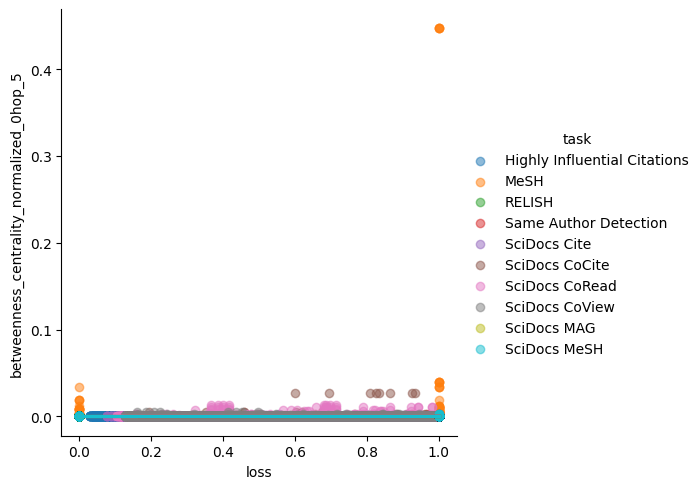

In [8]:
g = sns.lmplot(
    data=merged[(merged['metric'] != 'kendalltau')],
    x="loss", y=measure_name, hue="task", scatter_kws={'alpha': 0.5},
)

In [9]:
from linearmodels.panel import PanelOLS
from statsmodels.api import add_constant
panel = merged.dropna(subset=['year'])
panel['year'] = panel['year'].astype(int)
panel = panel.set_index(['doc_id', 'year'])

for task in [t for t in panel['task'].unique() if t not in ['SciDocs MAG', 'SciDocs MeSH']]:
    print(task)
    tp = panel[panel['task'] == task]
    model = PanelOLS(tp['loss'], add_constant(tp[[measure_name]]), entity_effects=False, time_effects=False)
    results = model.fit()
    print(results)

/tmp/ipykernel_332239/3035950565.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel['year'] = panel['year'].astype(int)


Citation Count
                          PanelOLS Estimation Summary                           
Dep. Variable:                   loss   R-squared:                        0.0327
Estimator:                   PanelOLS   R-squared (Between):              0.0742
No. Observations:                3160   R-squared (Within):               0.0000
Date:                Mon, Jun 24 2024   R-squared (Overall):              0.0327
Time:                        12:06:35   Log-likelihood                   -5702.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      106.92
Entities:                        7025   P-value                           0.0000
Avg Obs:                       0.4498   Distribution:                  F(1,3158)
Min Obs:                       0.0000                                           
Max Obs:                       40.000   F-statistic (robust):             106.92
             

In [10]:
merged['measure_quantile'] = merged[measure_name].transform(lambda x: pd.qcut(x, q=quantiles, duplicates='drop', labels=False)) + 1
pctile = np.percentile(impact[impact[measure_name].notna()][measure_name], ptile)
merged['high impact'] = merged[measure_name].transform(lambda x: x > pctile)
pctile

1.4337948850135442e-06

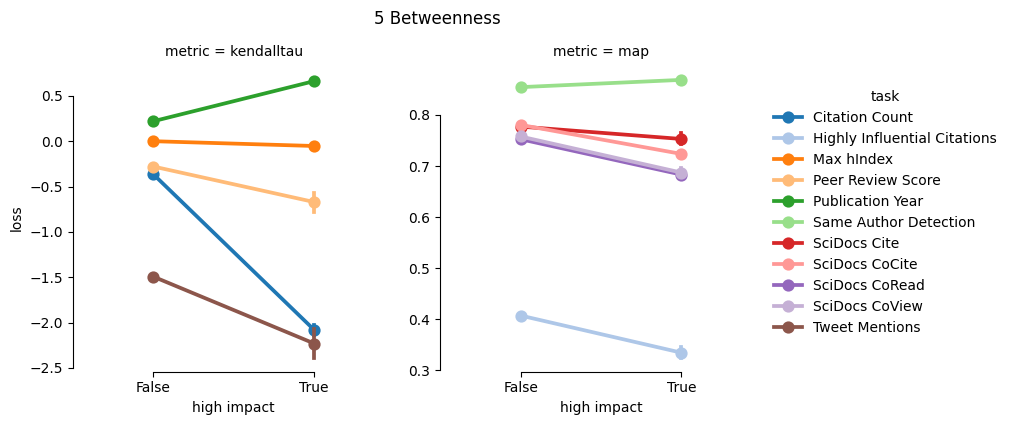

In [11]:
sns.catplot(x="high impact", y="loss",
            hue="task", col="metric", col_wrap=2,
            kind='point', sharey=False,
            data=merged[~merged['metric'].isin(['f1_macro', 'ndcg'])], palette='tab20',
            height=4)
sns.despine(offset=0, trim=True)
plt.suptitle('5 Betweenness', y=1.05, x=0.45)
plt.show()

In [12]:
merged[merged['metric'] == 'f1_macro'].groupby(['task','measure_quantile']).mean()

/tmp/ipykernel_332239/3758410012.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged[merged['metric'] == 'f1_macro'].groupby(['task','measure_quantile']).mean()


loss     corpus_id         year  \
task         measure_quantile                                        
MeSH         1                 0.812161  3.196559e+07  2017.760000   
             2                 0.809879  3.210235e+07  2015.222222   
             3                 0.810034  3.090074e+07  2018.000000   
             4                 0.809719  2.758571e+07  2013.541667   
SciDocs MAG  1                 0.882665  2.990385e+07  1997.269108   
             2                 0.927772  2.531986e+07  2001.820039   
             3                 0.896046  3.014679e+07  1999.948980   
             4                 0.893902  3.860525e+07  1994.394309   
SciDocs MeSH 1                 0.859862  2.941699e+07  2006.942211   
             2                 0.848422  2.865511e+07  2007.671805   
             3                 0.858503  2.865214e+07  2006.165334   
             4                 0.864431  2.330108e+07  2002.425844   

                                  record_id  \
task         measure_quantile                 
MeSH         1                 3.196559e+07   
             2                 3.210235e+07   
             3                 3.090074e+07   
             4                 2.758571e+07   
SciDocs MAG  1                 2.990385e+07   
             2                 2.531986e+07   
             3                 3.014679e+07   
             4                 3.860525e+07   
SciDocs MeSH 1                 2.941699e+07   
             2                 2.865511e+07   
             3                 2.865214e+07   
             4                 2.330108e+07   

                               betweenness_centrality_normalized_0hop_5  \
task         measure_quantile                                             
MeSH         1                                             7.930124e-10   
             2                                             2.046016e-08   
             3                                             1.172944e-07   
             4                                             9.776952e-06   
SciDocs MAG  1                                             5.446068e-10   
             2                                             1.995656e-08   
             3                                             1.188737e-07   
             4                                             3.575130e-06   
SciDocs MeSH 1                                             1.184113e-09   
             2                                             2.046651e-08   
             3                                             1.148259e-07   
             4                                             2.786507e-06   

                               high impact  
task         measure_quantile               
MeSH         1                    0.000000  
             2                    0.000000  
             3                    0.000000  
             4                    0.296781  
SciDocs MAG  1                    0.000000  
             2                    0.000000  
             3                    0.000000  
             4                    0.283740  
SciDocs MeSH 1                    0.000000  
             2                    0.000000  
             3                    0.000000  
             4                    0.227154

In [13]:
merged[merged['metric'] == 'kendalltau'].groupby(['task','measure_quantile']).mean()

/tmp/ipykernel_332239/2777262728.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged[merged['metric'] == 'kendalltau'].groupby(['task','measure_quantile']).mean()


loss     corpus_id         year  \
task              measure_quantile                                        
Citation Count    1                 0.101931  3.169148e+07  2016.000000   
                  2                -0.386563  3.244850e+07  2016.000000   
                  3                -0.631257  3.228093e+07  2016.000000   
                  4                -1.397387  3.665738e+07  2016.000000   
Max hIndex        1                 0.012086  1.854207e+08          NaN   
                  2                 0.006103  1.821046e+08          NaN   
                  3                -0.015217  1.684686e+08          NaN   
                  4                -0.035468  1.447894e+08          NaN   
Peer Review Score 1                -0.155652  1.726427e+08          NaN   
                  2                -0.263545  1.648523e+08          NaN   
                  3                -0.388821  1.528300e+08          NaN   
                  4                -0.622592  1.235082e+08          NaN   
Publication Year  1                 0.163983  9.183974e+07  2016.409933   
                  2                 0.186657  8.799663e+07  2016.423461   
                  3                 0.249883  8.222626e+07  2016.108739   
                  4                 0.453710  7.080798e+07  2014.829630   
Tweet Mentions    1                -1.412134  1.009747e+08          NaN   
                  2                -1.478053  1.045285e+08          NaN   
                  3                -1.492817  9.917196e+07          NaN   
                  4                -1.903595  8.628863e+07          NaN   

                                       record_id  \
task              measure_quantile                 
Citation Count    1                 3.169148e+07   
                  2                 3.244850e+07   
                  3                 3.228093e+07   
                  4                 3.665738e+07   
Max hIndex        1                 1.854207e+08   
                  2                 1.821046e+08   
                  3                 1.684686e+08   
                  4                 1.447894e+08   
Peer Review Score 1                 1.726427e+08   
                  2                 1.648523e+08   
                  3                 1.528300e+08   
                  4                 1.235082e+08   
Publication Year  1                 9.183974e+07   
                  2                 8.799663e+07   
                  3                 8.222626e+07   
                  4                 7.080798e+07   
Tweet Mentions    1                 1.009747e+08   
                  2                 1.045285e+08   
                  3                 9.917196e+07   
                  4                 8.628863e+07   

                                    betweenness_centrality_normalized_0hop_5  \
task              measure_quantile                                             
Citation Count    1                                             1.041597e-09   
                  2                                             2.087139e-08   
                  3                                             1.168608e-07   
                  4                                             5.007206e-06   
Max hIndex        1                                             9.929261e-10   
                  2                                             2.042940e-08   
                  3                                             1.111264e-07   
                  4                                             1.621107e-06   
Peer Review Score 1                                             9.687904e-10   
                  2                                             2.083726e-08   
                  3                                             1.128493e-07   
                  4                                             1.639936e-06   
Publication Year  1                                             1.035927e-09   
                  2                         

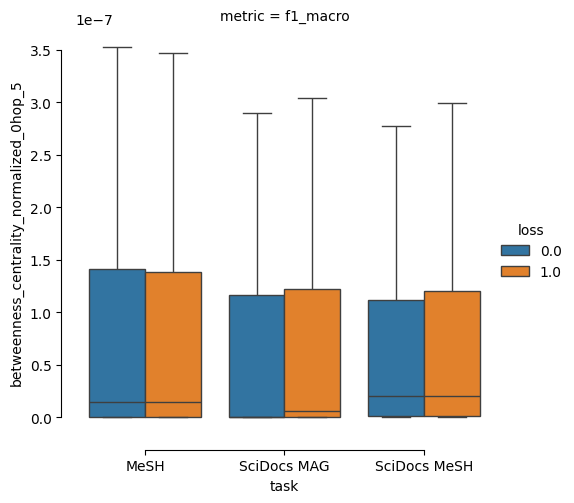

In [14]:
sns.catplot(x="task", y=measure_name,
            hue="loss", col="metric", kind='box', sharey=False, 
            data=merged[merged['metric'] == 'f1_macro'], showfliers=False)
sns.despine(offset=10, trim=True)